In [1]:
from data_processing import *
pd.options.display.width = 0
#%matplotlib inline

# Set the task and experiment type
task_name = 'swda'

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_mean_data.csv'))

# Get the max values for each model
vocab_data_max = get_max(vocab_mean_data, exp_param)
print("Best validation accuracy in mean data:")
print(vocab_data_max.loc[[vocab_data_max['val_acc'].idxmax()], ['model_name', 'val_' + exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(vocab_data_max.loc[[vocab_data_max['test_acc'].idxmax()], ['model_name', 'test_' + exp_param, 'test_acc', 'f1_micro']])
vocab_data_max

Best validation accuracy in mean data:
  model_name  val_vocab_size   val_acc
7   text cnn            5500  0.756117
Best test accuracy in mean data:
  model_name  test_vocab_size  test_acc  f1_micro
5       lstm             2500  0.729049  0.730449


,model_name,val_vocab_size,val_acc,test_vocab_size,test_acc,f1_micro
0,bi gru,4000,0.731305,8000,0.718470,0.720103
1,bi lstm,8000,0.749769,8000,0.728060,0.729566
2,cnn,2500,0.744975,7500,0.718491,0.719735
3,dcnn,7500,0.751531,8000,0.726971,0.728389
4,gru,8000,0.738904,6500,0.719435,0.720961
5,lstm,7000,0.752472,2500,0.729049,0.730449
6,rcnn,7500,0.743606,7000,0.717692,0.719294
7,text cnn,5500,0.756117,2500,0.728534,0.729958


Plot accuracy of each model per vocabulary size.

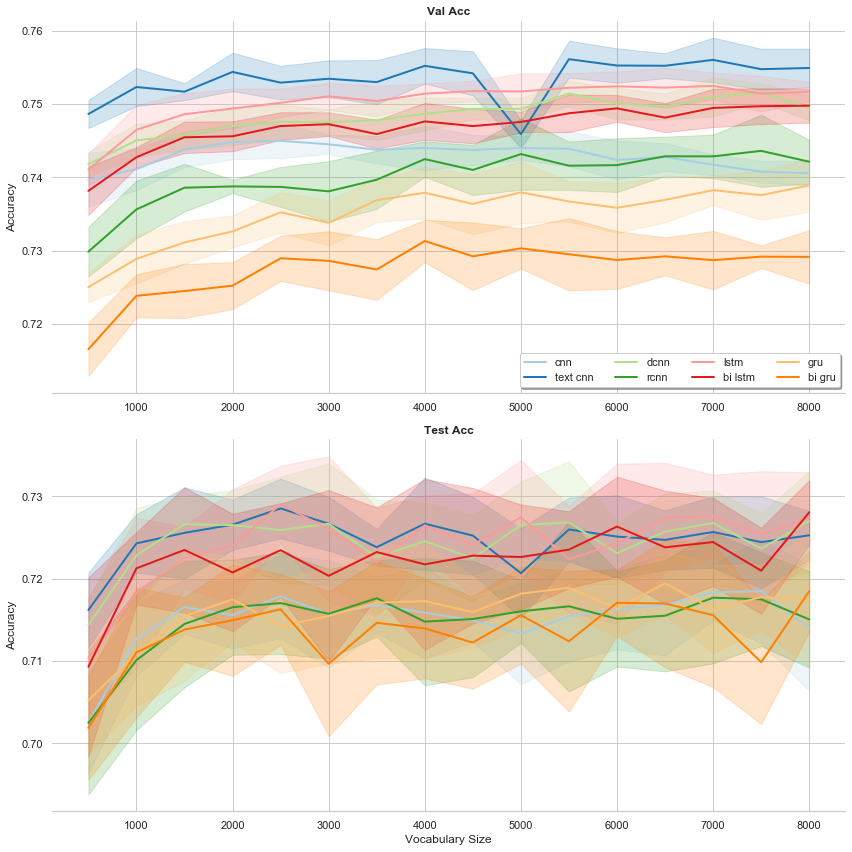

In [3]:
# TODO remove test data
# Get test and validation accuracy for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_relplot(vocab_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
                      title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
                      legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [4]:
# Set the metric to test and statistical significance level
metric = 'val_acc'
sig_level = 0.05

# Run Shaprio-wilks for all models and vocabulary sizes
shapiro_frame = shapiro_wilk_test(vocab_data, exp_param, metric)

if all(p_value > sig_level for p_value in shapiro_frame['p-value']):
    print("All models " + exp_param + " are normally distributed.")
else:
    print("The following " + exp_param + " are not normally distributed.")
    print(shapiro_frame.loc[shapiro_frame['p-value'] <= sig_level])

# Run Levene test for equal variance
levene_frame = levene_test(vocab_data, exp_param, metric)

if all(p_value > sig_level for p_value in levene_frame['p-value']):
    print("All models " + exp_param + " have equal variance.")
else:
    print("The following models " + exp_param + " do not have equal variance.")
    print(levene_frame.loc[levene_frame['p-value'] <= sig_level])

levene_frame

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825526  0.029553
50       rcnn       1500  0.838140  0.041916
62       rcnn       7500  0.753436  0.003930
76       lstm       6500  0.815659  0.022455
87    bi lstm       4000  0.814240  0.021584
All models vocab_size have equal variance.


,model_name,t-stat,p-value
0,cnn,1.413760,0.148137
1,text cnn,0.766139,0.712889
2,dcnn,0.549283,0.908151
3,rcnn,0.893647,0.572526
4,lstm,0.960897,0.499452
5,bi lstm,0.936507,0.525635
6,gru,0.577683,0.888292
7,bi gru,1.005563,0.452810


Perform ANOVA for each model, comparing different vocabulary size groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [5]:
# Run ANOVA
anova_frame = anova_test(vocab_data, exp_param, metric)

if all(p_value <= sig_level for p_value in anova_frame['PR(>F)']):
    print("All models have significant p-values when comparing " + exp_param + " groups.")
else:
    print("The following models do not have significant p-values when comparing " + exp_param + " groups.")
    print(anova_frame.loc[anova_frame['PR(>F)'] > sig_level])

anova_frame

All models have significant p-values when comparing vocab_size groups.


,F,PR(>F),df,eta_sq,mean_sq,omega_sq,sum_sq
cnn,5.326351,2.025392e-08,15.0,0.356842,0.000028,0.288558,0.000416
text cnn,12.568081,1.593483e-19,15.0,0.566945,0.000076,0.520270,0.001136
dcnn,15.746608,1.838878e-23,15.0,0.621251,0.000065,0.580272,0.000982
rcnn,10.350516,1.795819e-16,15.0,0.518809,0.000125,0.467124,0.001876
lstm,17.218715,3.891193e-25,15.0,0.642041,0.000086,0.603254,0.001293
bi lstm,18.407561,1.987861e-26,15.0,0.657235,0.000089,0.620055,0.001336
gru,14.953782,1.597458e-22,15.0,0.609022,0.000148,0.566756,0.002217
bi gru,10.018167,5.446340e-16,15.0,0.510658,0.000128,0.458128,0.001918


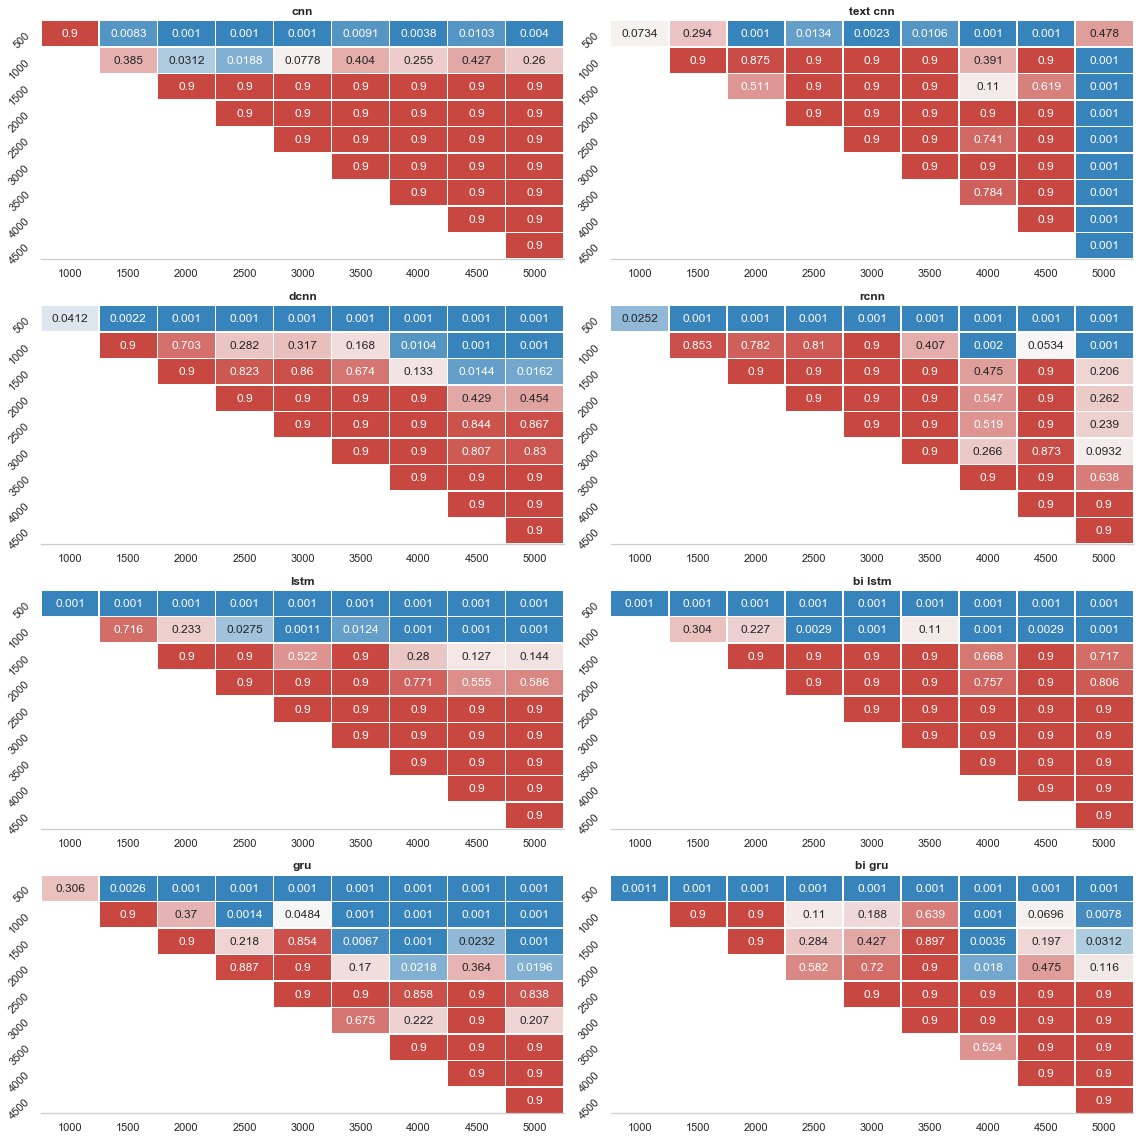

In [6]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric)

# Drop the un-needed columns and generate heatmaps
tukey_frame = tukey_frame.drop(columns=['meandiff', 'lower', 'upper', 'reject'], axis=1)
# Remove vocab_size > 5000 to make plots nicer
tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)

g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [7]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_mean_data.csv'))

# Get the max values for each model
seq_data_max = get_max(seq_mean_data, exp_param)
print("Best validation accuracy in mean data:")
print(seq_data_max.loc[[seq_data_max['val_acc'].idxmax()], ['model_name', 'val_' + exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(seq_data_max.loc[[seq_data_max['test_acc'].idxmax()], ['model_name', 'test_' + exp_param, 'test_acc', 'f1_micro']])
seq_data_max

Best validation accuracy in mean data:
  model_name  val_max_seq_length  val_acc
7   text cnn                  25  0.75633
Best test accuracy in mean data:
  model_name  test_max_seq_length  test_acc  f1_micro
5       lstm                   50  0.729147  0.730547


,model_name,val_max_seq_length,val_acc,test_max_seq_length,test_acc,f1_micro
0,bi gru,30,0.735057,50,0.720430,0.722015
1,bi lstm,35,0.748553,50,0.723076,0.724589
2,cnn,45,0.744300,35,0.717816,0.719196
3,dcnn,30,0.751016,35,0.726751,0.728169
4,gru,25,0.739449,40,0.721055,0.722726
5,lstm,25,0.753496,50,0.729147,0.730547
6,rcnn,40,0.744993,50,0.721986,0.723633
7,text cnn,25,0.756330,20,0.728208,0.729493


Plot accuracy of each model per sequence length.

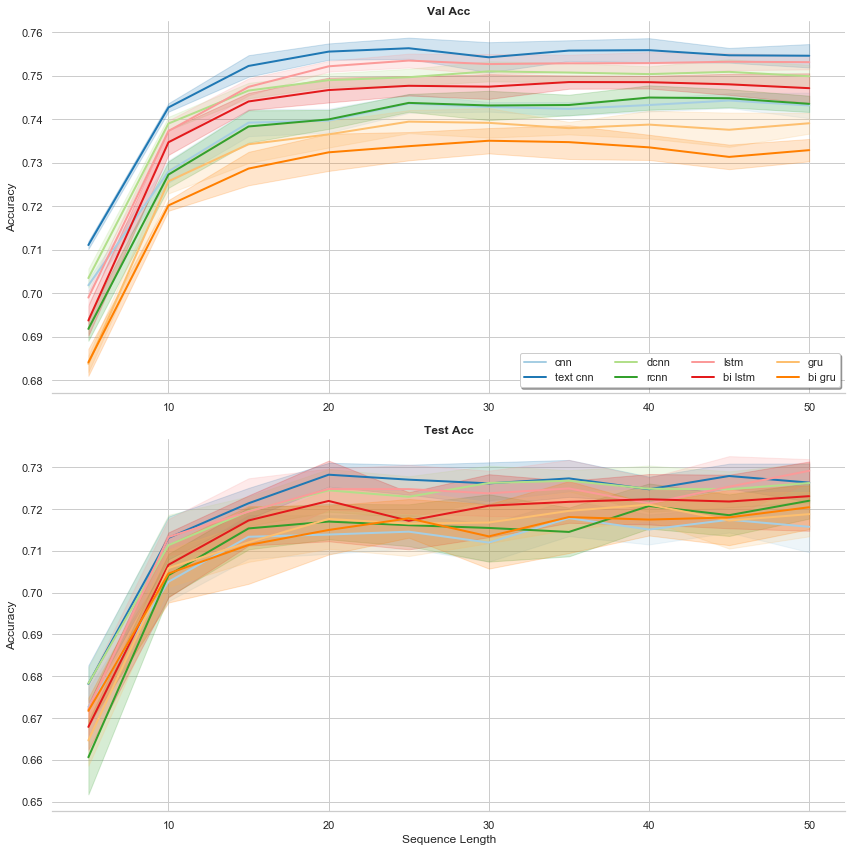

In [8]:
# TODO remove test data
# Get test and validation accuracy for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_relplot(seq_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
                      title='', y_label='Accuracy', x_label='Sequence Length',  share_x=False, share_y=False, num_col=1,
                      legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [9]:
# Set the metric to test and statistical significance level
metric = 'val_acc'
sig_level = 0.05

# Run Shaprio-wilks for all models and sequence lengths)

if all(p_value > sig_level for p_value in shapiro_frame['p-value']):
    print("All models " + exp_param + " are normally distributed.")
else:
    print("The following " + exp_param + " are not normally distributed.")
    print(shapiro_frame.loc[shapiro_frame['p-value'] <= sig_level])

# Run Levene test for equal variance
levene_frame = levene_test(seq_data, exp_param, metric)

if all(p_value > sig_level for p_value in levene_frame['p-value']):
    print("All models " + exp_param + " have equal variance.")
else:
    print("The following models " + exp_param + " do not have equal variance.")
    print(levene_frame.loc[levene_frame['p-value'] <= sig_level])

levene_frame

The following max_seq_length are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825526  0.029553
50       rcnn       1500  0.838140  0.041916
62       rcnn       7500  0.753436  0.003930
76       lstm       6500  0.815659  0.022455
87    bi lstm       4000  0.814240  0.021584
All models max_seq_length have equal variance.


,model_name,t-stat,p-value
0,cnn,1.431609,0.186555
1,text cnn,1.864271,0.067530
2,dcnn,0.679021,0.725923
3,rcnn,1.326725,0.234409
4,lstm,1.140888,0.342903
5,bi lstm,1.435222,0.185065
6,gru,0.563222,0.823687
7,bi gru,0.808153,0.609863


Perform ANOVA for each model, comparing different sequence length groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [10]:
# Run ANOVA
anova_frame = anova_test(seq_data, exp_param, metric)

if all(p_value <= sig_level for p_value in anova_frame['PR(>F)']):
    print("All models have significant p-values when comparing " + exp_param + " groups.")
else:
    print("The following models do not have significant p-values when comparing " + exp_param + " groups.")
    print(anova_frame.loc[anova_frame['PR(>F)'] > sig_level])

anova_frame

All models have significant p-values when comparing max_seq_length groups.


,F,PR(>F),df,eta_sq,mean_sq,omega_sq,sum_sq
cnn,364.465080,8.926812e-67,9.0,0.973295,0.001744,0.970337,0.015699
text cnn,372.079519,3.614924e-67,9.0,0.973827,0.001967,0.970928,0.017700
dcnn,480.181912,4.985668e-72,9.0,0.979599,0.002166,0.977338,0.019494
rcnn,374.900643,2.597900e-67,9.0,0.974019,0.002703,0.971141,0.024330
lstm,760.126463,7.580867e-81,9.0,0.987015,0.002914,0.985574,0.026222
bi lstm,428.025018,7.810157e-70,9.0,0.977170,0.002895,0.974640,0.026052
gru,323.453113,1.631616e-64,9.0,0.970011,0.002951,0.966690,0.026561
bi gru,239.557288,7.261034e-59,9.0,0.959929,0.002429,0.955497,0.021862


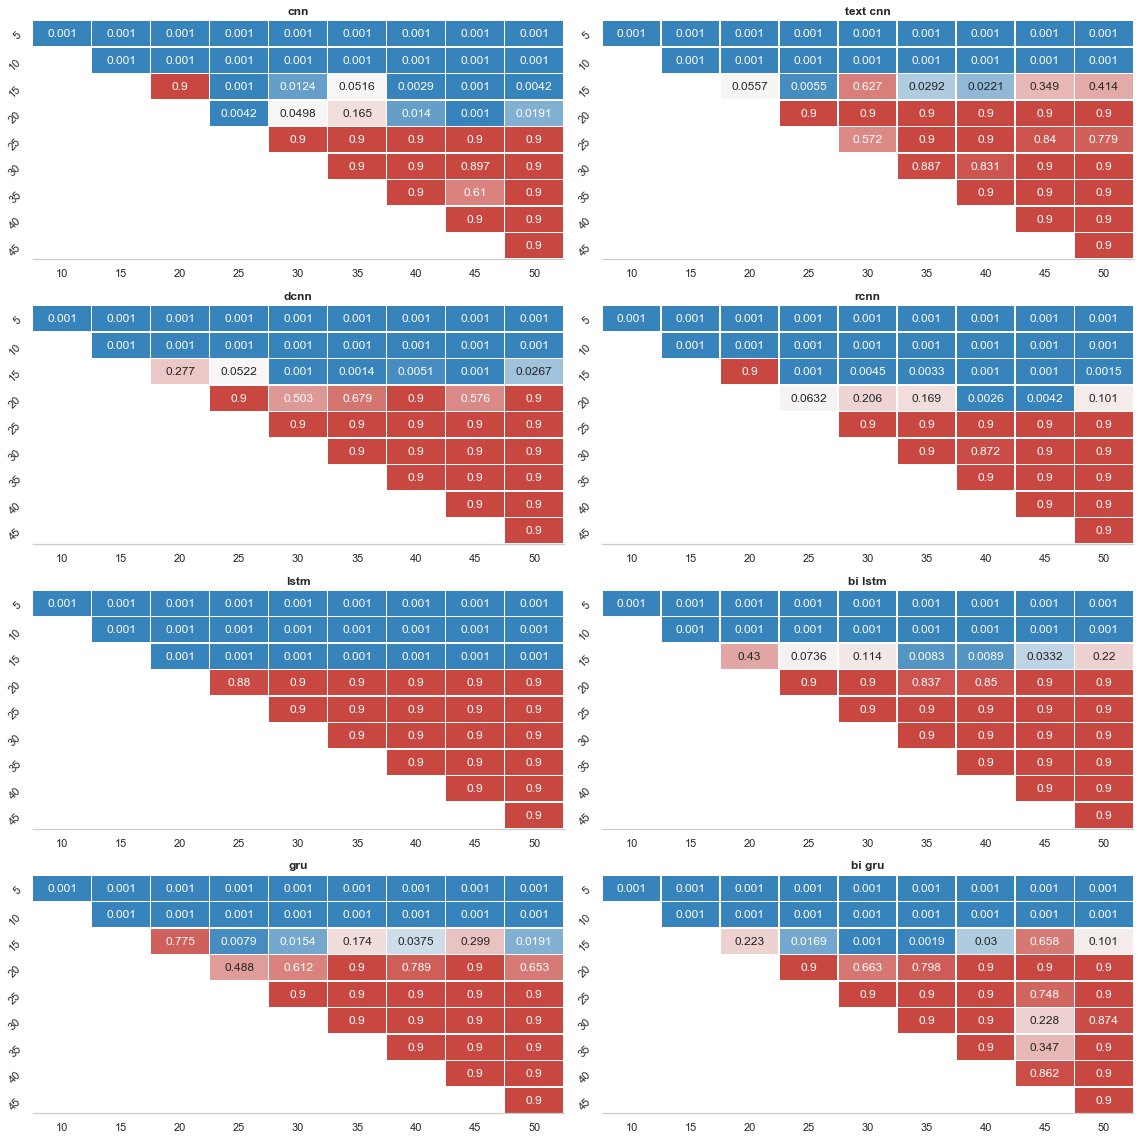

In [11]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric)

# Drop the un-needed columns and generate heatmaps
tukey_frame = tukey_frame.drop(columns=['meandiff', 'lower', 'upper', 'reject'], axis=1)

g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Use Punctuation
Whether to remove punctuation from the input sentences or not.

Show punctuation flag value corresponding to max validation and test accuracy per model.

In [12]:
# Name of the experiment parameter for comparison
exp_param = 'use_punct'

# Load punctuation experiment data
punc_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_data.csv'))
punc_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param +'_mean_data.csv'))

# Get the max values for each model
punc_data_max = get_max(punc_mean_data, exp_param)
print("Best validation accuracy in mean data:")
print(punc_data_max.loc[[punc_data_max['val_acc'].idxmax()], ['model_name', 'val_' + exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(punc_data_max.loc[[punc_data_max['test_acc'].idxmax()], ['model_name', 'test_' + exp_param, 'test_acc', 'f1_micro']])
punc_data_max

Best validation accuracy in mean data:
  model_name  val_use_punct  val_acc
7   text cnn          False  0.75611
Best test accuracy in mean data:
  model_name  test_use_punct  test_acc  f1_micro
3       dcnn           False   0.72798  0.729542


,model_name,val_use_punct,val_acc,test_use_punct,test_acc,f1_micro
0,bi gru,False,0.729192,False,0.715492,0.717112
1,bi lstm,False,0.748794,False,0.722832,0.724344
2,cnn,False,0.744598,False,0.715265,0.716524
3,dcnn,False,0.750176,False,0.727980,0.729542
4,gru,False,0.736974,False,0.714360,0.715837
5,lstm,False,0.752520,False,0.723397,0.724884
6,rcnn,False,0.740616,False,0.719982,0.721500
7,text cnn,False,0.756110,False,0.727905,0.729272


Plot accuracy of each model per punctuation flag value.

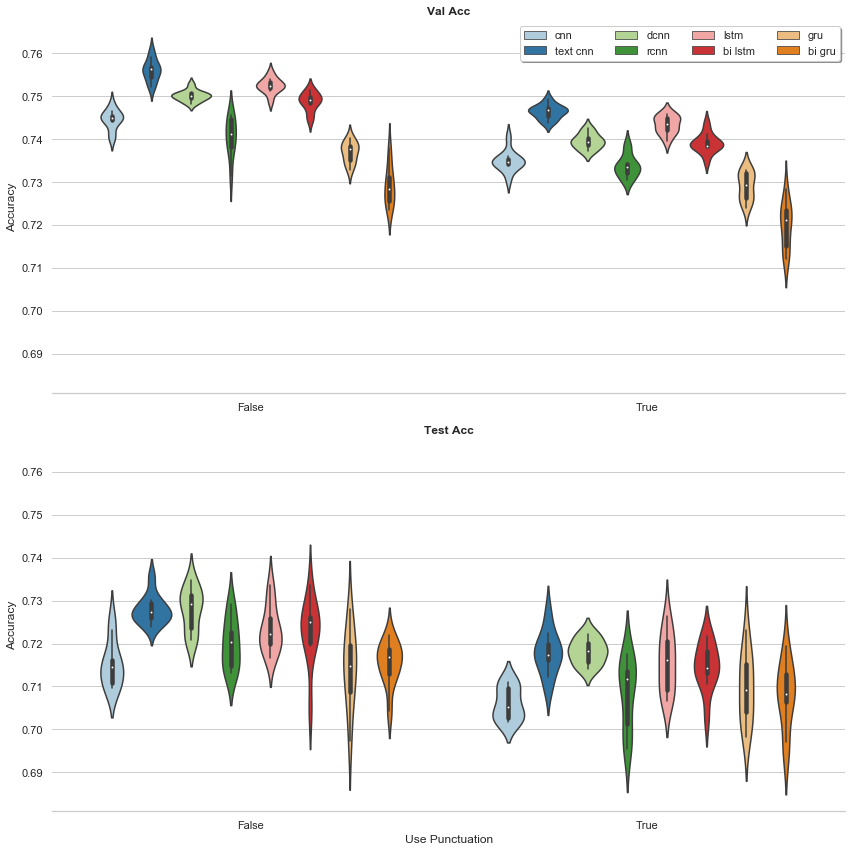

In [13]:
# TODO remove test data
# Get test and validation accuracy for each model
punc_acc_data = punc_data.drop(punc_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
punc_acc_data = punc_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
punc_acc_data = punc_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(punc_acc_data, x=exp_param, y="value", hue="model_name", col='variable', kind='violin',
                            num_legend_col=4, y_label='Accuracy', x_label='Use Punctuation',
                            share_y=True, num_col=1, dodge=True, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [14]:
# Set the metric to test and statistical significance level
metric = 'val_acc'
sig_level = 0.05

# Run Shaprio-wilks for all models and punctuation flag value
shapiro_frame = shapiro_wilk_test(punc_data, exp_param, metric)

if all(p_value > sig_level for p_value in shapiro_frame['p-value']):
    print("All models " + exp_param + " are normally distributed.")
else:
    print("The following " + exp_param + " are not normally distributed.")
    print(shapiro_frame.loc[shapiro_frame['p-value'] <= sig_level])

# Run Levene test for equal variance
levene_frame = levene_test(punc_data, exp_param, metric)

if all(p_value > sig_level for p_value in levene_frame['p-value']):
    print("All models " + exp_param + " have equal variance.")
else:
    print("The following models " + exp_param + " do not have equal variance.")
    print(levene_frame.loc[levene_frame['p-value'] <= sig_level])

levene_frame

All use_punct are normally distributed.
All models use_punct have equal variance.


,model_name,t-stat,p-value
0,cnn,0.003713,0.952082
1,text cnn,0.933978,0.346638
2,dcnn,1.061295,0.316565
3,rcnn,1.836328,0.192145
4,lstm,1.592342,0.223099
5,bi lstm,0.038891,0.845874
6,gru,2.199544,0.155350
7,bi gru,0.187997,0.669741


Perform t-test comparing punctuation true and false for each model.

In [15]:
# Run t-test
t_frame = t_test(punc_data, exp_param, metric)

if all(p_value <= sig_level for p_value in t_frame['p-value']):
    print("All models have significant p-values when comparing " + exp_param + " groups.")
else:
    print("The following models do not have significant p-values when comparing " + exp_param + " groups.")
    print(anova_frame.loc[anova_frame['p-value'] > sig_level])

t_frame

All models have significant p-values when comparing use_punct groups.


,model_name,t-stat,p-value
0,cnn,9.093682,3.774000e-08
1,text cnn,10.175668,6.826824e-09
2,dcnn,15.490012,7.518729e-12
3,rcnn,4.263384,4.675678e-04
4,lstm,10.489057,4.262169e-09
5,bi lstm,9.742328,1.332627e-08
6,gru,6.132616,8.599319e-06
7,bi gru,4.163449,5.837580e-04


# TODO Input Sequence Combinations

Combination | Punc True | Punc False
----------- | :-------: | :--------:
Seq=50 Voc=5k   | [x]       | []
Seq=128 Voc=5k  | [x]       | []
Seq=50 Voc=10k  | [x]       | []
Seq=128 Voc=10k | []        | []

# TODO Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency (and random?) for each model.
Dimension increments of 50 in range [100, 300].

# TODO Attentional / multi-layer models

# Language Models

Using pre-trained language models to generate sequence representations.

In [16]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models' +'_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models' +'_mean_data.csv'))

# Get the max values for each model
lm_data_max = get_max(lm_mean_data, exp_param)
lm_data_max.drop(['val_embedding_type', 'test_embedding_type'], axis=1, inplace=True)
print("Best validation accuracy in mean data:")
print(lm_data_max.loc[[lm_data_max['val_acc'].idxmax()], ['model_name', 'val_acc']])
print("Best test accuracy in mean data:")
print(lm_data_max.loc[[lm_data_max['test_acc'].idxmax()], ['model_name', 'test_acc', 'f1_micro']])
lm_data_max

Best validation accuracy in mean data:
  model_name   val_acc
1       bert  0.768694
Best test accuracy in mean data:
  model_name  test_acc  f1_micro
1       bert  0.760679  0.762099


,model_name,val_acc,test_acc,f1_micro
0,elmo,0.759993,0.731891,0.733636
1,bert,0.768694,0.760679,0.762099
2,use,0.762036,0.735063,0.736210
3,nnlm,0.734443,0.701229,0.702206
4,mlstm char lm,0.757773,0.734759,0.736210


Plot accuracy of each language model.

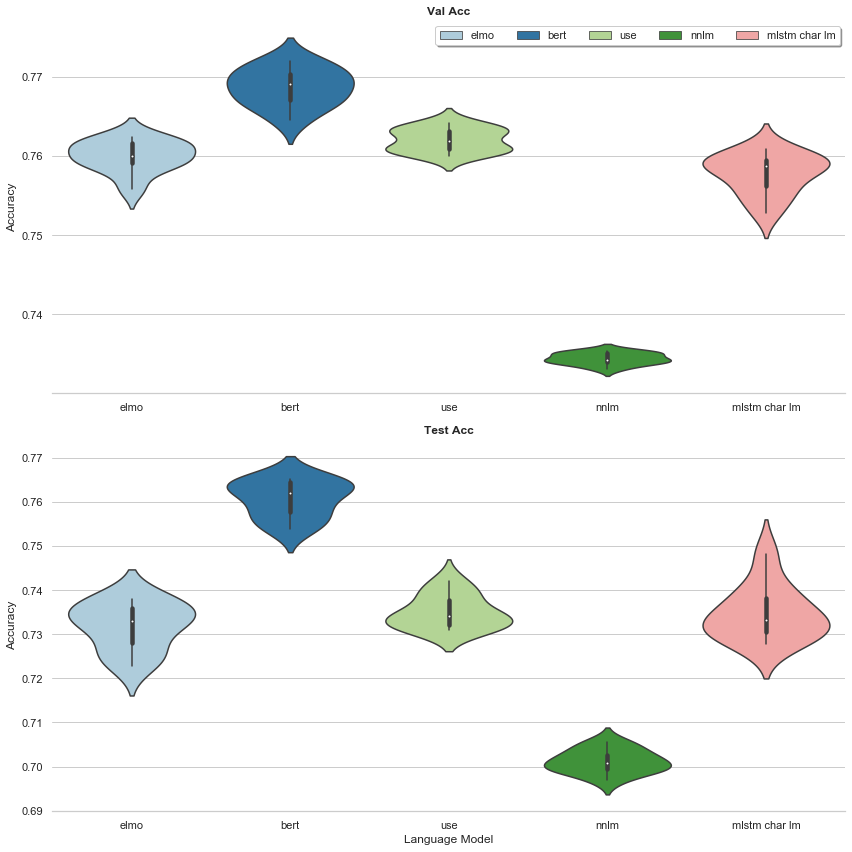

In [30]:
# TODO remove test data
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

# g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='bar',
#                         title='', y_label='Accuracy', x_label='Language Model',
#                         share_y=True, num_col=1, show_bar_value=True, dodge=False, num_legend_col=5, legend_loc='best')

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='violin',
                        num_legend_col=5, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)

# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))